# Random Forest Notebook


In [1]:

from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
import json
import os
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Load dataset
df = pd.read_csv(r"C:\Users\aryan\Desktop\XAI\XAI_Models\time_series\dataset3\energydata_complete.csv")

                       date    Appliances        lights            T1  \
count                 19735  19735.000000  19735.000000  19735.000000   
unique                19735           NaN           NaN           NaN   
top     2016-01-11 17:00:00           NaN           NaN           NaN   
freq                      1           NaN           NaN           NaN   
mean                    NaN     97.694958      3.801875     21.686571   
std                     NaN    102.524891      7.935988      1.606066   
min                     NaN     10.000000      0.000000     16.790000   
25%                     NaN     50.000000      0.000000     20.760000   
50%                     NaN     60.000000      0.000000     21.600000   
75%                     NaN    100.000000      0.000000     22.600000   
max                     NaN   1080.000000     70.000000     26.260000   

                RH_1            T2          RH_2            T3          RH_3  \
count   19735.000000  19735.000000  19735.0

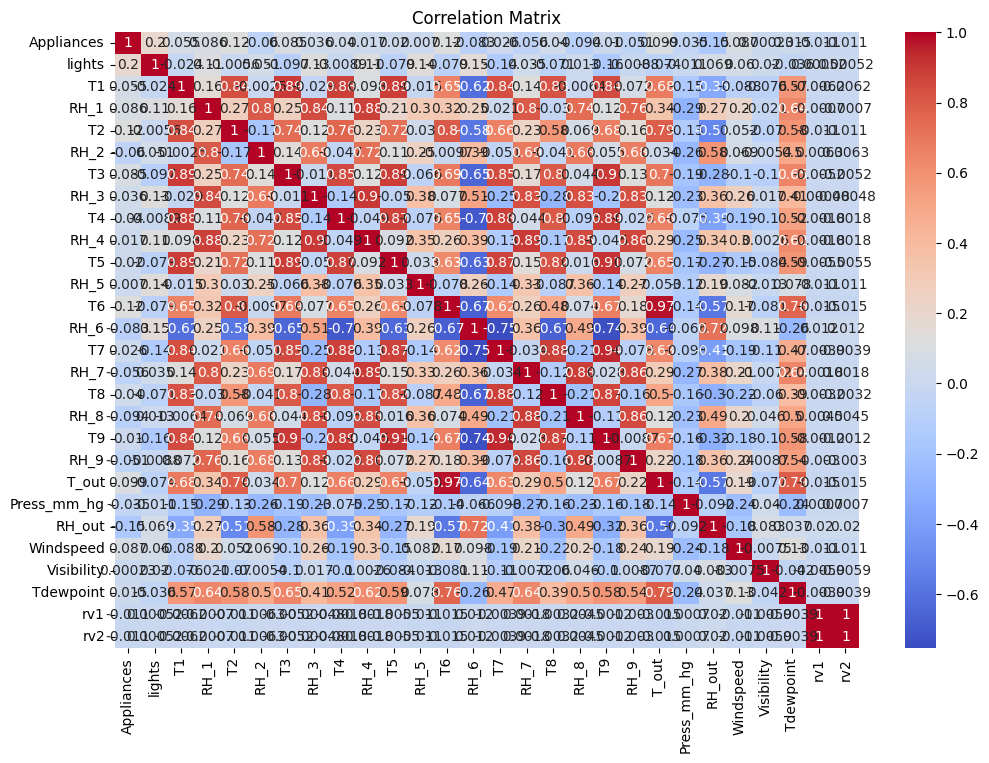

In [3]:
# Display basic statistics
print(df.describe(include='all'))

# Correlation matrix for numerical columns only
numerical_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_df.corr()
print(correlation_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

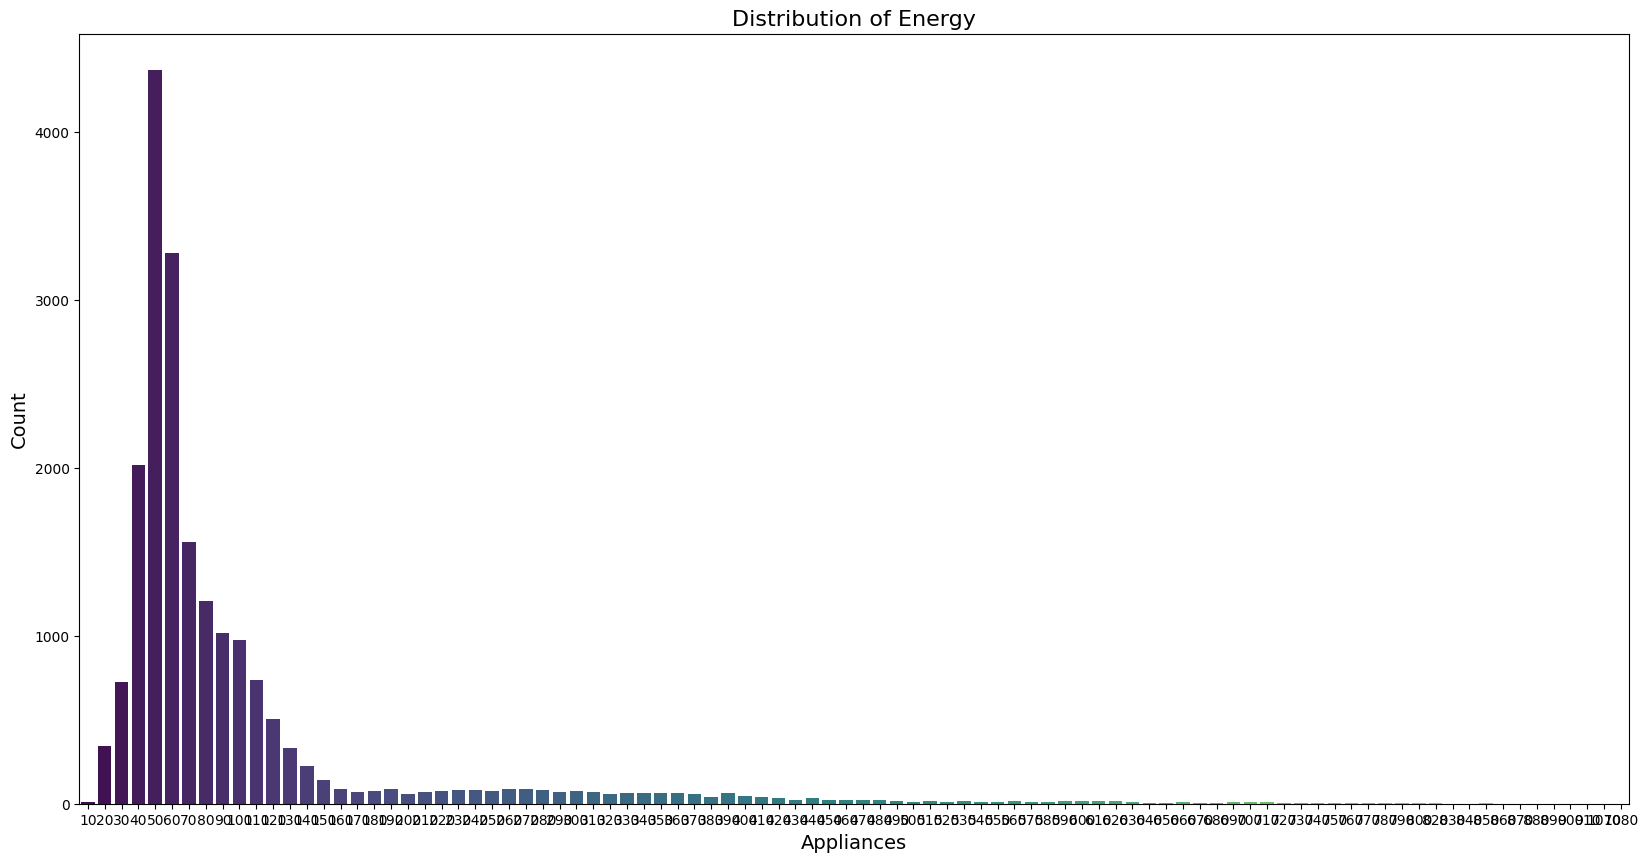

In [4]:
plt.figure(figsize=(20, 10))
sns.countplot(x='Appliances', data=df, palette='viridis')
plt.title('Distribution of Energy', fontsize=16)
plt.xlabel('Appliances', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

In [5]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d %H:%M:%S")
df = df.groupby("date")["Appliances"].sum().reset_index()
df = df.sort_values("date")
df

,date,Appliances
0,2016-01-11 17:00:00,60
1,2016-01-11 17:10:00,60
2,2016-01-11 17:20:00,50
3,2016-01-11 17:30:00,50
4,2016-01-11 17:40:00,60
...,...,...
19730,2016-05-27 17:20:00,100
19731,2016-05-27 17:30:00,90
19732,2016-05-27 17:40:00,270
19733,2016-05-27 17:50:00,420


In [6]:
# Train-test split
test_size = int(len(df) * 0.2)
train, test = df.iloc[:-test_size].copy(), df.iloc[-test_size:].copy()


In [7]:
# Ensure "Appliances" column exists in both train and test sets
if "Appliances" not in train.columns or "Appliances" not in test.columns:
    raise KeyError("The 'Appliances' column is missing from train or test dataset!")

In [8]:
# Define numerical features
numerical_features = ["Appliances"]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ]
)

In [9]:
from sklearn.model_selection import cross_val_score

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create the model with the suggested hyperparameters
    rf_regressor = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', rf_regressor)
    ])

    # Perform cross-validation on the training data
    scores = cross_val_score(pipeline, train.drop(columns=['date']), train['Appliances'], cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
    return scores.mean()


In [10]:
# Check if the hyperparameters are already stored in the JSON file

model_name = 'Random Forest'
json_file = f'{model_name}.json'

if os.path.exists(json_file):
    with open(json_file, 'r') as file:
        best_params = json.load(file)
else:
    # Optimize the hyperparameters using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params

    # Save the best hyperparameters to the JSON file
    with open(json_file, 'w') as file:
        json.dump(best_params, file)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Remove the 'model' key from best_params if it exists
best_params.pop('model', None)

# Create the model with the best hyperparameters
rf_regressor = RandomForestRegressor(**best_params)

# Create the pipeline with the best hyperparameters
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_regressor)
])


# Check if the JSON file contains hyperparameters
if 'n_estimators' in best_params:
    # Use the hyperparameters from the JSON file
    rf_regressor = RandomForestRegressor(**best_params)
else:
    # Optimize the hyperparameters using Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params

    # Save the best hyperparameters to the JSON file
    with open(json_file, 'w') as file:
        json.dump(best_params, file)

    # Create the model with the best hyperparameters
    rf_regressor = RandomForestRegressor(**best_params)
    

[I 2025-02-26 18:55:06,732] A new study created in memory with name: no-name-45ff906a-f3cc-4a07-a39f-7fff69fcae0d


Best Hyperparameters: {'model': 'Random Forest'}


[I 2025-02-26 18:55:10,505] Trial 0 finished with value: -0.07200891369038978 and parameters: {'n_estimators': 152, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: -0.07200891369038978.
[I 2025-02-26 18:55:14,431] Trial 1 finished with value: -0.054740686165202265 and parameters: {'n_estimators': 352, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: -0.07200891369038978.
[I 2025-02-26 18:55:17,146] Trial 2 finished with value: -0.13158518925935522 and parameters: {'n_estimators': 229, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 2 with value: -0.13158518925935522.
[I 2025-02-26 18:55:19,692] Trial 3 finished with value: -0.08232927473527649 and parameters: {'n_estimators': 229, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 2 with value: -0.13158518925935522.
[I 2025-02-26 18:55:20,816] Trial 4 finished with value: -0.1086159780946

In [11]:
# Create the pipeline with the best hyperparameters
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf_regressor)
])

# Define the features and target
X_train = train.drop(columns=['date'])
y_train = train['Appliances']

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Appliances'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=3, min_samples_leaf=7,
                                       n_estimators=68))])

In [12]:
# Perform cross-validation on the training data
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, n_jobs=-1)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.97807773 0.98044836 0.98214499 0.97924223 0.98129685]
Mean cross-validation score: 0.9802420325122988


In [13]:
# Predict on the test data
y_pred = pipeline.predict(test)

In [14]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Calculate regression metrics
r2 = r2_score(test['Appliances'], y_pred)
mae = mean_absolute_error(test['Appliances'], y_pred)
mse = mean_squared_error(test['Appliances'], y_pred)
rmse = mean_squared_error(test['Appliances'], y_pred, squared=False)

print(f"R2 Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


R2 Score: 0.977240688722909
Mean Absolute Error (MAE): 10.12146876151812
Mean Squared Error (MSE): 188.62948918689318
Root Mean Squared Error (RMSE): 13.73424512621255


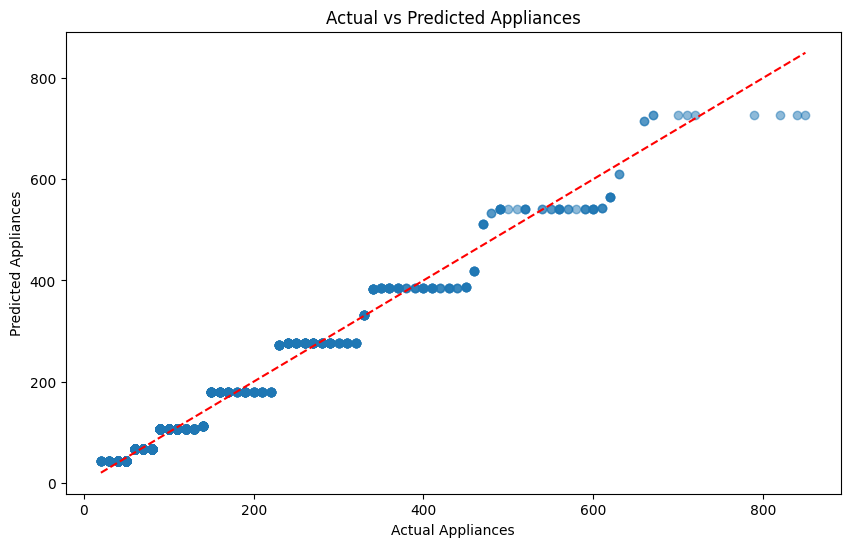

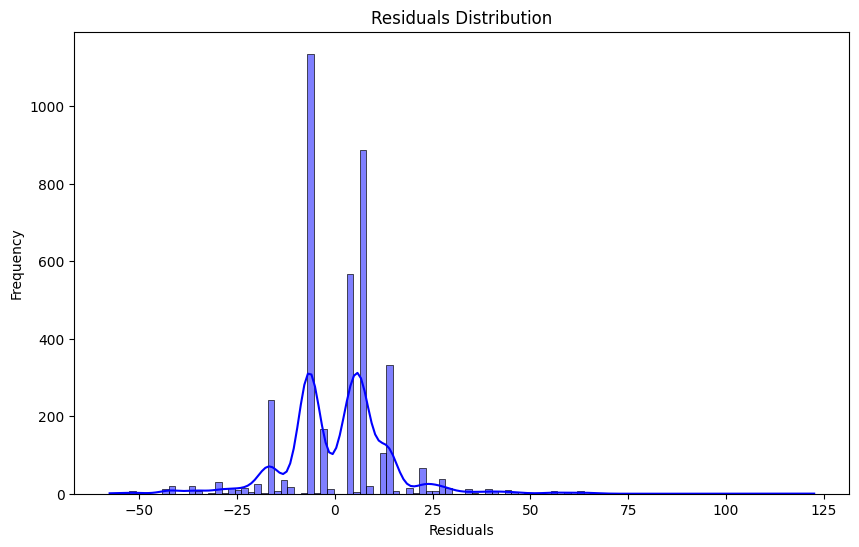

In [15]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(test['Appliances'], y_pred, alpha=0.5)
plt.plot([test['Appliances'].min(), test['Appliances'].max()], [test['Appliances'].min(), test['Appliances'].max()], 'r--')
plt.title('Actual vs Predicted Appliances')
plt.xlabel('Actual Appliances')
plt.ylabel('Predicted Appliances')
plt.show()

# Residual plot
residuals = test['Appliances'] - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

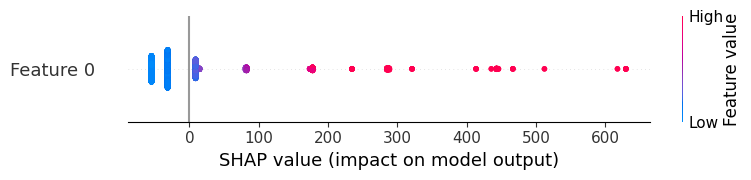

In [16]:
# Define X_test and y_test
X_test = test.drop(columns=['date'])
y_test = test['Appliances']

# Transform X_test using the preprocessor
X_test_transformed = preprocessor.transform(X_test)

# Calculate SHAP values
explainer = shap.TreeExplainer(rf_regressor)
shap_values = explainer.shap_values(X_test_transformed)

# Explainability using SHAP summary plot
shap.summary_plot(shap_values, X_test_transformed)

In [17]:
# Store metrics
metrics_data = []
# Append results
metrics_data.append({
    "Model": model_name,
    "R2_Score": r2,
    "Mean Absolute Error": mae,
    "Mean Squared Error": mse,
    "Root Mean Squared Error": rmse
})

# Save metrics to a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
metrics_df.to_csv("random_forest_metrics.csv", index=False)

In [18]:
import joblib

# Assuming the model is trained in your .ipynb session and available in memory
# Replace 'model' with the actual variable holding your trained model
joblib.dump(rf_regressor, 'random_forest.pkl')

print("Model saved successfully as 'random_forest.pkl'")


Model saved successfully as 'random_forest.pkl'
